In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"

# Libraries and Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from llms.nucl_classifier.dnabert import NuclDNABERT
from schemas.train_params import TrainParams

# Params and Files

In [3]:
seed = 12

csv_path = "nucl-500.csv"
pretrained_model_name = "NuclDNABERT"

In [4]:
csv_path = f"./storage/data/processed/{csv_path}"
output_path = f"./storage/models/tuned/{pretrained_model_name}"
checkpoint = "./storage/models/base/dnabert2"

# Reading Dataset

In [5]:
df = pd.read_csv(csv_path, keep_default_na=False)

# Loading Model

In [6]:
llm = NuclDNABERT(
  checkpoint=checkpoint,
  seed=seed,
  flank_size=24,
  max_length=512 
)

/home-lib/gustavo.cruz/.cache/huggingface/modules/transformers_modules/dnabert2/bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./storage/models/base/dnabert2 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Data Processing

In [7]:
data = df.to_dict(orient="records")

In [8]:
all_dataset = []
for record in tqdm(data):
  example = llm.build_input(
    sequence=record["sequence"],
    target=record["target"]
	)
  all_dataset.append(example)

train_dataset, test_dataset = train_test_split(
  all_dataset,
  test_size=0.05,
  random_state=seed,
  shuffle=True
)

  0%|          | 0/57687 [00:00<?, ?it/s]

100%|██████████| 57687/57687 [00:00<00:00, 2511384.36it/s]


# Data Analysis

In [9]:
print("Train Dataset Len:", len(train_dataset))
print("Test Dataset Len:", len(test_dataset))

Train Dataset Len: 54802
Test Dataset Len: 2885


In [10]:
train_lengths = [len(example["sequence"]) for example in train_dataset]
test_lengths = [len(example["sequence"]) for example in test_dataset]

Train Dataset Len: 54802
Test Dataset Len: 2885


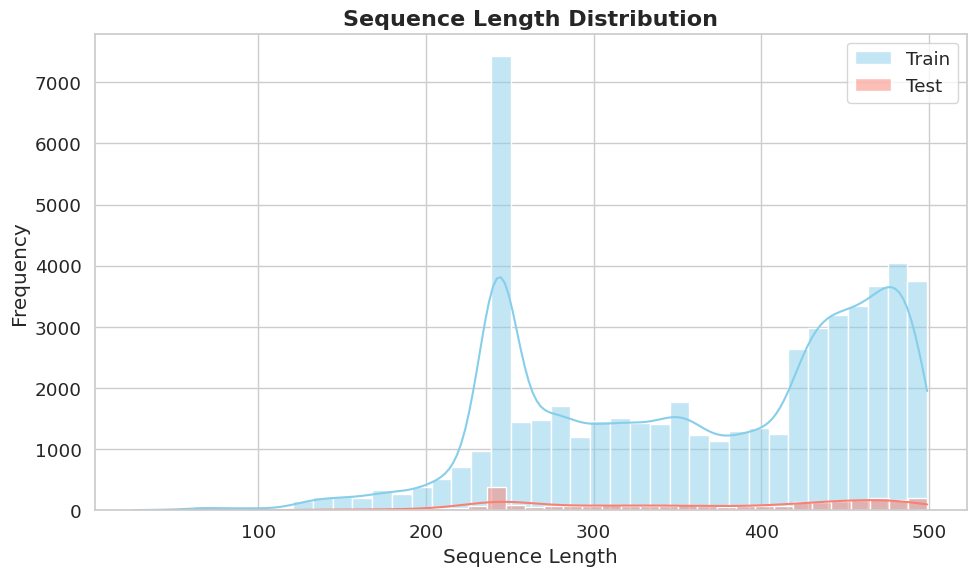

In [11]:
print("Train Dataset Len:", len(train_dataset))
print("Test Dataset Len:", len(test_dataset))

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

plt.figure(figsize=(10, 6))
sns.histplot(train_lengths, kde=True, bins=40, color="skyblue", label="Train")
sns.histplot(test_lengths, kde=True, bins=40, color="salmon", label="Test")

plt.title("Sequence Length Distribution", fontsize=16, weight="bold")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# Training

In [12]:
llm.train(
  dataset=train_dataset,
  params=TrainParams(
    epochs=3,
    batch_size=64,
    gradient_accumulation=1,
    lr=5e-6,
    logging_steps=5000
	)
)

2025-11-03 09:54:14,022 - INFO - Preparing dataset...
100%|██████████| 54802/54802 [21:47<00:00, 41.93it/s]  
2025-11-03 10:28:01,605 - INFO - Dataset prepared!
2025-11-03 10:28:01,608 - INFO - Dataset length: 19987319
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-11-03 10:28:04,545 - INFO - Starting training...
/home-lib/gustavo.cruz/miniconda3/envs/dna/lib/python3.13/site-packages/torch/n

Step,Training Loss
5000,0.668500
10000,0.574500
15000,0.541800
20000,0.518500
25000,0.499900
30000,0.484500
35000,0.471300
40000,0.458800
45000,0.445000
50000,0.436100


2025-11-03 17:19:52,286 - INFO - Training complete. You may save the model for later usage.


# Saving The Model

In [13]:
llm.save_pretrained(output_path)

2025-11-03 17:19:52,386 - INFO - Attempting to save model at './storage/models/tuned/NuclDNABERT'
2025-11-03 17:19:56,925 - INFO - Successfully saved at './storage/models/tuned/NuclDNABERT'


# Test

In [14]:
refs = []
preds = []

for data in tqdm(test_dataset):
  answer = llm.generate(data)
  preds.append(answer)
  refs.append(data["target"])

100%|██████████| 2885/2885 [3:52:02<00:00,  4.83s/it]  


In [ ]:
all_refs = []
all_preds = []
for ref, pred in zip(refs, preds):
  min_len = min(len(ref), len(pred))
  all_refs.extend(list(ref[:min_len]))
  all_preds.extend(list(pred[:min_len]))

acc = accuracy_score(all_refs, all_preds)

print("Accuracy: ", acc)

labels = ["I", "E", "U"]
precision, recall, f1, support = precision_recall_fscore_support(
	all_refs, all_preds, labels=labels, average=None, zero_division=0
)

assert isinstance(precision, np.ndarray)
assert isinstance(recall, np.ndarray)
assert isinstance(f1, np.ndarray)

for i, label in enumerate(labels):
	print(f"Class: '{label}'")
	print(f"  - Precision: {precision[i]:.4f}")
	print(f"  - Recall:   {recall[i]:.4f}")
	print(f"  - F1-Score: {f1[i]:.4f}\n")

Accuracy:  0.7890230793066644
Class: 'I'
  - Precision: 0.6007
  - Recall:   0.6113
  - F1-Score: 0.6060

Class: 'E'
  - Precision: 0.8011
  - Recall:   0.9011
  - F1-Score: 0.8482

Class: 'U'
  - Precision: 0.8096
  - Recall:   0.6697
  - F1-Score: 0.7331



: 